**This notebook demonstrates MS-HS image fusion using SURE and BP:**
- Data: Assuming that HSI has higher noise than MSE
    - Simulated LR HSI data are generated by apply the PSF filtering and downsampling to the HR HSI, and adding Gaussian noise. There two cases of noise (1)isotropic Gaussian noise added to MSI, LR HSI such as SNRs are 40 dB and 30 dB, respectively; (2) band-dependent Gaussian noise where $\sigma$ for each band is random number from drawn from uniform distribution $\mathcal{U}(0, 0.1)$; i.e. $\mathbf{Y}=\mathbf{HX}+\mathbf{n}$.
    - Simulated MSI data are generated by downsampling the spectral using spectral respon function (SRF), e.g., Ikonos SRF, resulting 4 MSI bands. ($\mathbf{G} = \mathbf{RX}$)
- Loss function $$\mathcal{L}_{sure}=\|\mathbf{P}(\mathbf{y}-\mathbf{H}f_\theta(\mathbf{y})\|^2)+2\text{tr}\big[(\Omega_P)\mathbf{PH}\frac{\partial f_\theta(\mathbf{z})}{\partial\mathbf{u}}\big],$$
where $\mathbf{P}$ is a linear operator mapping LR image to its HR space, $\mathbf{z}$ is the network input (concatenating $\mathbf{\mathbf{u}=H^\dagger y}$ and $\mathbf{G}$) and $f_\theta(\cdot)$ is the network output.

In [1]:
# =============================================================================
# import lib
# =============================================================================
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import matplotlib.pyplot as plt
import numpy as np
import math
import torch
import torch.optim
import scipy.io as sio
from skimage.metrics import peak_signal_noise_ratio as psnr
from models.hs_models import *
from utils.hs_utils import *
from utils.common_utils import *
print(torch.cuda.get_device_name())

NVIDIA GeForce GTX 1080 Ti


In [2]:
# =============================================================================
# load data
# =============================================================================
path_to_data = 'data/HS/pu_hsms.mat'
X = sio.loadmat(path_to_data)['Zim'] # Ground truth (HR HSI)
srf = sio.loadmat(path_to_data)['R'] #spectral response
R=np.transpose(srf)
factor=4
[r,c,n_channels]=X.shape
X_torch=torch.from_numpy(X).to(device,dtype=torch.float)
R_torch=torch.from_numpy(R).to(device,dtype=torch.float)
##########Simulate MSI bands
MSI=hwc2chw(hsi2msi(X_torch,R_torch))
scale_m=torch.max(MSI)
MSI=MSI/scale_m
SNRm=40.
[msi,sigmam]=add_noise(MSI,SNRm)
##########Simulate HSI bands
####Get PSF for the HSI, gaussian = False -->Starg-Mutargh filter
psf=get_hs_psf(N=15, n_channels = n_channels, gaussian=True,sigma=2.)
x=hwc2chw(X_torch).to(device,dtype=torch.float)
# Generate LR-HSI by filtering, downsampling (factor = 4) and adding noise
hsi_LR = Ax(x,psf,ratio=factor) #hs
## Case 2: Uniform sigma (0-0.1)
# sigmah = torch.rand(n_channels,1)*0.1 
# hsi=add_bandwise_noise(hsi_LR,sigmah)
# Case 1: isotropic Gaussian noise
SNRh=30.
[hsi,sigmah]=add_noise(hsi_LR,SNRh)
cond=1e-3
hsiup = back_projx(hsi,psf,factor,cond)
ref = X #np
# sigmah=sigmah.reshape(n_channels,1,1).to(device) #need this for Case 2

MS bands shape:  torch.Size([4, 200, 200])
HS bands shape:  torch.Size([93, 50, 50])
torch.Size([])
30.027193108605307
39.99521682852436


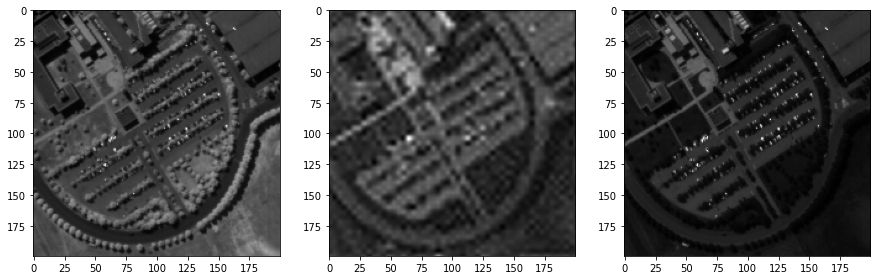

In [3]:
## Image information
###==================
print('MS bands shape: ', msi.shape)
print('HS bands shape: ', hsi.shape)
print(sigmah.shape)
print(SNRCal(hsi_LR.cpu().numpy(),hsi.cpu().numpy()))
print(SNRCal(MSI.cpu().numpy(),msi.cpu().numpy()))

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False, figsize=(15,15))
ax1.imshow(msi[3,:,:].cpu(),cmap='gray')
ax2.imshow(hsiup[11,:,:].cpu(),cmap='gray')
ax3.imshow(ref[:,:,11],cmap='gray')
plt.show()

In [4]:
# =============================================================================
# Set parameters and net
# =============================================================================
show_every = 200 #500
num_iter = 3001
LR = 0.01 #try 0.01 0.001 0.0001

net=hs_net(ym_channel=4, yh_channel=n_channels, num_channels_down=64, 
           num_channels_up=64, num_channels_skip=16).to(device)

# net_inputs = [torch.randn(msi.shape).to(device),torch.randn(hsi_lr.shape).to(device)]
net_inputs = torch.cat((msi,hsiup),dim=0)[None,:] #Noisy MSI and HSI
targets=[msi,hsi]
gband=4 #4 for ms
optimizer = torch.optim.Adam(net.parameters(), lr=LR, eps=1e-3, amsgrad=True)

In [5]:
####Loss function (SURE)
def hs_loss(model,inputs,targets,psf_hs, R, sigmah,sigmam,cond,loss_type='sure'):
    '''SURE and DIP losses'''
#     gband=4
    ym = targets[0] #ms
    yh=targets[1] #hs = target
    sigmah_sq=sigmah**2
    sigmam_sq=sigmam**2
    ratio=4
    xhat=model(inputs)
    yhat=Ax(xhat.squeeze(),psf_hs,ratio) - yh
    pyhat = back_projx(yhat,psf_hs,ratio,cond)
    dip_loss = torch.sum((yh-yhat)**2)
    out_msi_torch = hwc2chw(hsi2msi(chw2hwc(xhat.squeeze()),R))/scale_m #Nxnm
    #### Compute the trace (divergence) term by using Monte-Carlo SURE  
    epsilon = 1e-5
    b = torch.randn(inputs.shape).to(device,dtype=torch.float)
    outb = (model(inputs+epsilon*b)-xhat)/epsilon
    outb_m = hwc2chw(hsi2msi(chw2hwc(outb.squeeze()),R))/scale_m*sigmam_sq #Nxnm
    Houtb_h = Ax(outb.squeeze(), psf_hs, ratio)
    tmp=invAAtx(Houtb_h,psf_hs,ratio,cond)*sigmah_sq
    outep = back_projx(tmp,psf_hs,ratio,cond)

    divh = 2 * torch.sum(b.squeeze()[4:,:,:] * outep) 
    divm= 2*torch.sum(b.squeeze()[:4,:,:]*outb_m) 
    bp_loss = torch.sum((ym-out_msi_torch)**2) + 0.1*torch.sum(pyhat**2) #lambda = 0.01 for Case 1
    sure_loss = bp_loss + divm + 0.1*divh
    if loss_type=='bp':
        return bp_loss, xhat
    elif loss_type=='sure':
        return  sure_loss, xhat
    else:
        return  print('Not this loss') 

Starting optimization with ADAM


<ipython-input-6-f5820066e487>:26: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  sre = psnr(ref,out_np)


Iteration 00000  Loss = 57779.09375 PSNR = 9.153


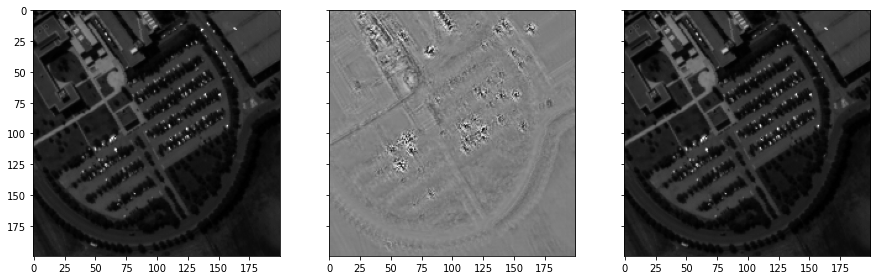

Iteration 00200  Loss = 122.76056 PSNR = 34.529


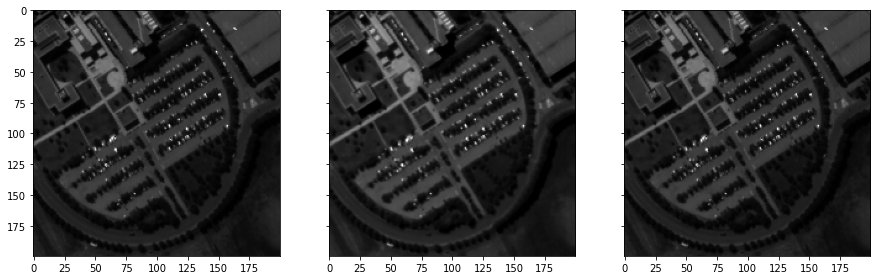

Iteration 00400  Loss = 99.28456 PSNR = 36.879


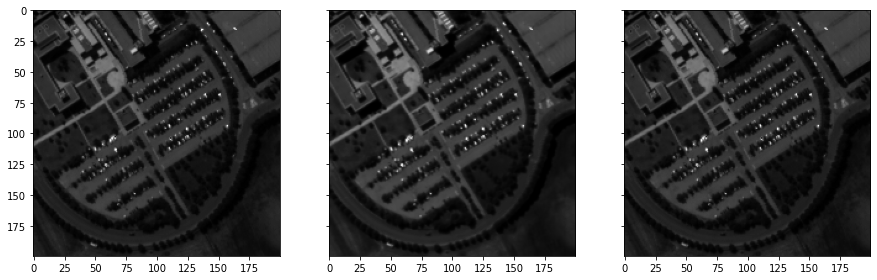

Iteration 00600  Loss = 91.22459 PSNR = 37.926


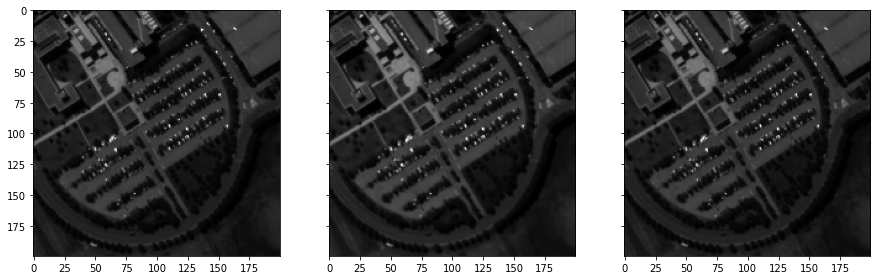

Iteration 00800  Loss = 89.99397 PSNR = 38.415


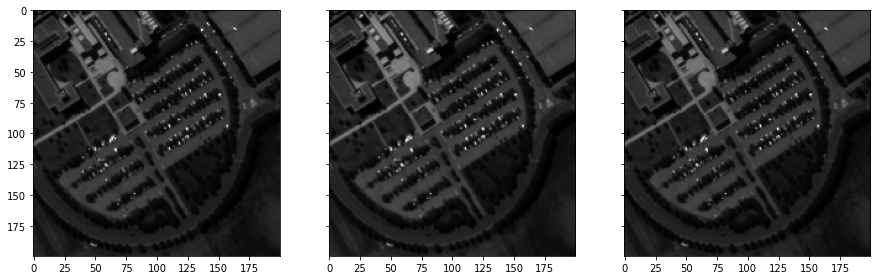

Iteration 01000  Loss = 86.54565 PSNR = 38.960


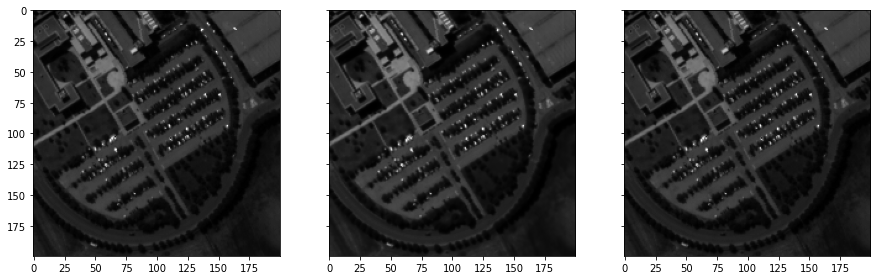

Iteration 01200  Loss = 85.88139 PSNR = 39.215


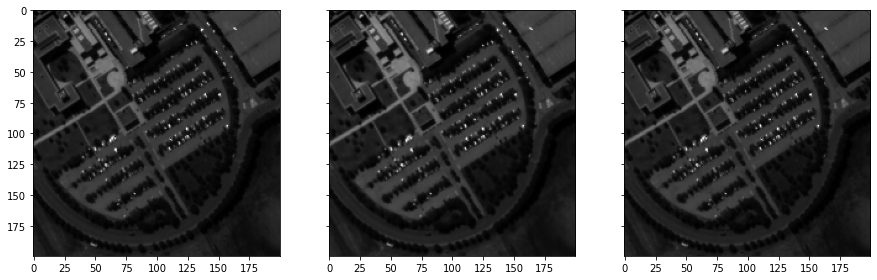

Iteration 01400  Loss = 84.61781 PSNR = 39.513


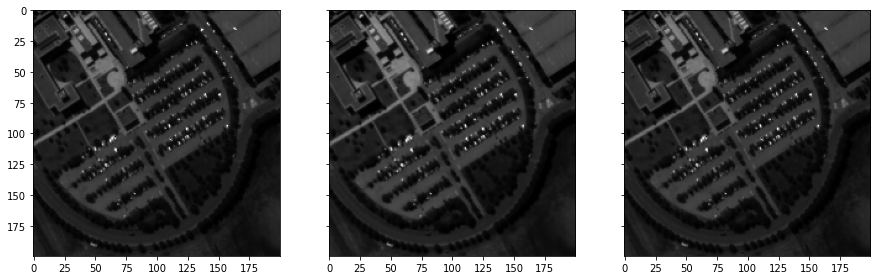

Iteration 01600  Loss = 84.12328 PSNR = 39.644


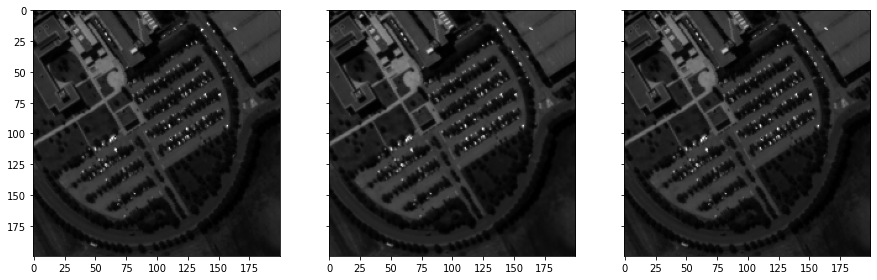

Iteration 01800  Loss = 82.18793 PSNR = 39.966


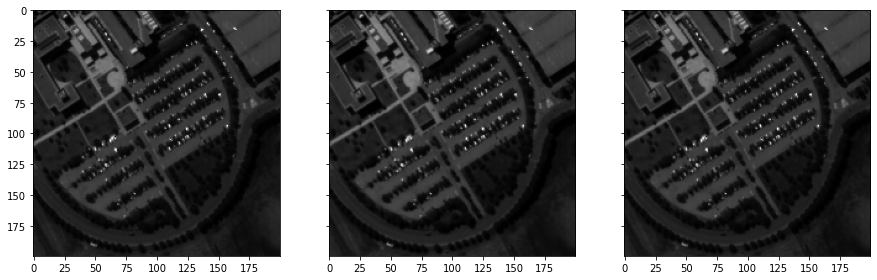

Iteration 02000  Loss = 82.13213 PSNR = 40.085


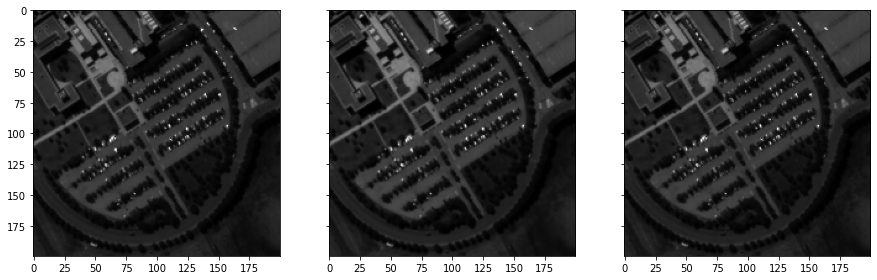

Iteration 02200  Loss = 81.83519 PSNR = 40.235


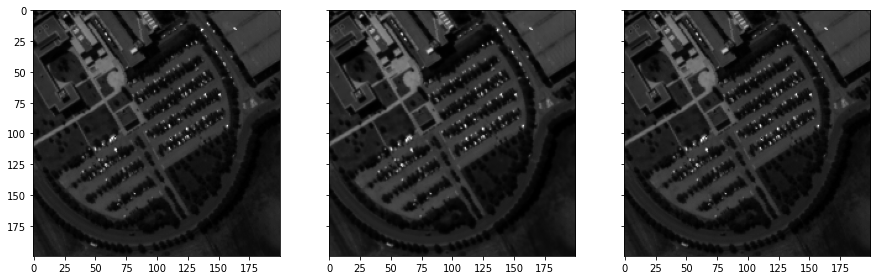

Iteration 02400  Loss = 80.96717 PSNR = 40.460


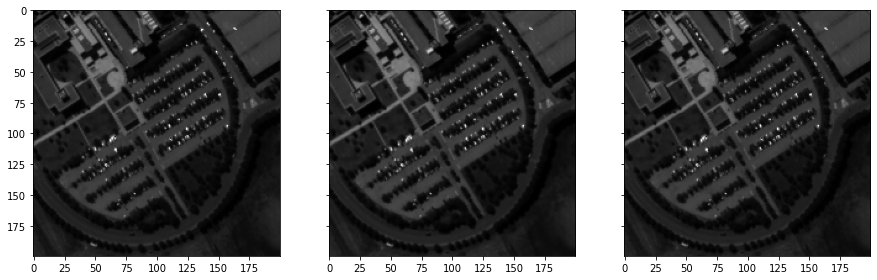

Iteration 02600  Loss = 80.84920 PSNR = 40.600


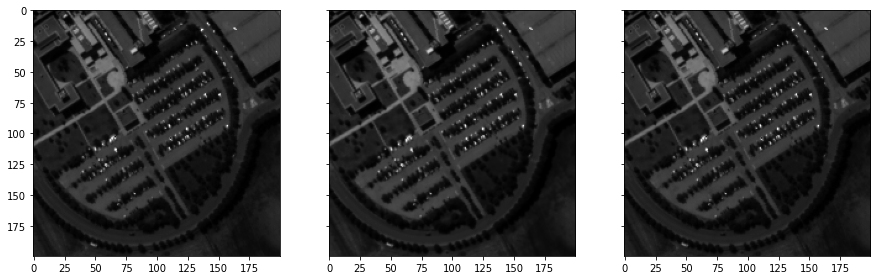

Iteration 02800  Loss = 80.47204 PSNR = 40.708


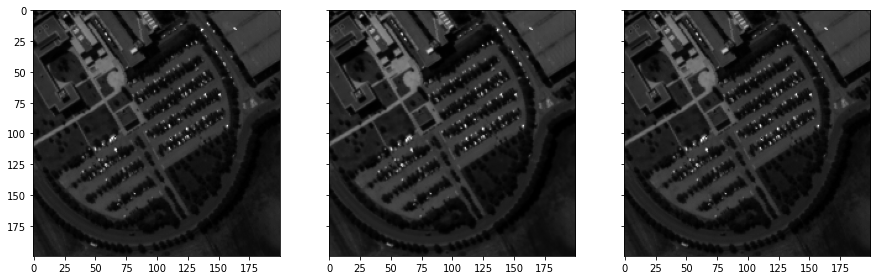

Iteration 03000  Loss = 80.29154 PSNR = 40.752


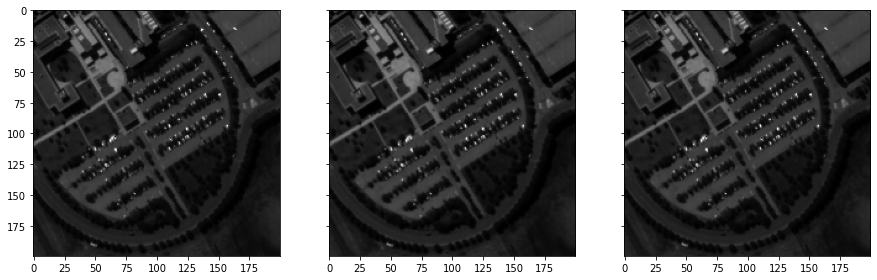

In [6]:
# =============================================================================
# Optimization
# =============================================================================
total_loss=[]
sre_history=[]
div_term = []
true_R=[]
print('Starting optimization with ADAM')
sre_init=0.
loss_type="sure"
out_avg=None
exp_weight=0.99
for it in range(num_iter):
    optimizer.zero_grad()
    loss, out_HR = hs_loss(net,net_inputs,targets,psf,R_torch,sigmah,sigmam,cond,loss_type=loss_type)
    # Track the PSNR of reconstructed image
    out_np = chw2hwc(out_HR.detach().cpu().squeeze()).numpy()
    
#     if out_avg is None:
#         out_avg = out_np
#     else:
#         out_avg = out_avg * exp_weight + out_np * (1 - exp_weight)
#     if it==3000:
#         sio.savemat("dc_out"+loss_type+"30n"+".mat",mdict={"img_"+loss_type:out_avg,"ref":ref,"sigmah":sigmah.cpu().numpy()})
    
    sre = psnr(ref,out_np)
    sre_history.append(sre)
    total_loss.append(loss.detach())
    loss.backward()
    optimizer.step()
    if it % show_every == 0:
        print('Iteration %05d  Loss = %.5f PSNR = %.3f' % (it,loss.detach(),sre))
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,15))
        ax1.imshow(ref[:,:,41],cmap='gray')
        ax2.imshow(out_np[:,:,41],cmap='gray')
        ax3.imshow(ref[:,:,41],cmap='gray')
        plt.show()

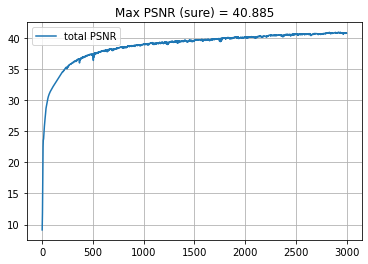

In [7]:
psnr_history=np.array(sre_history)
a=np.max(psnr_history)
plt.plot(psnr_history,label='total PSNR')

plt.title('Max PSNR (sure) = '+str(np.round(a,3)))
plt.legend()
plt.grid()
plt.show()